In [1]:
#import libraries and packages
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from dsutil.plotting import calibration_accuracy_plot
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from numpy import argmax
from numpy import arange
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from imblearn.pipeline import make_pipeline
from imblearn import FunctionSampler


We define some functions, that will be useful in the future analysis: to_labels function is used to transform probabilities, that the model develops, into 0/1 output; pos_recall function is used to calculate the recall of class 1 (subjects with diabetes); outlier_rejection function is used to get rid of outliers in the sample inside of the Pipeline. 

In [2]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
def pos_recall(estimator, X, y):
    y_pred = estimator.predict(X)  
    rec = recall_score(y, y_pred,pos_label=1, average='binary')
    return rec
def outlier_rejection(X, y):
    model = IsolationForest(max_samples=100, contamination=0.4, random_state=42)
    model.fit(X)
    y_pred = model.predict(X)
    return X[y_pred == 1], y[y_pred == 1]


Any analysis will suffer, if there are hidden patterns in the missing values. We can handle missing values in many ways, but first we need to understand which missing values we have, and why. While a lady might not have any kids (min value in Pregnancies variable can be 0), it is unfeasible that Glucose, BloodPressure, SkinThickness, Insulin and BMI can be 0. Therefore, we interpret these 0 values as missing values. We want to replace all 0 in these columns with NaN's, since they are easy to handle in Python.

In [3]:
df_full = pd.read_csv(r'/Users/alexfion/sciebo/python_WS/data/diabetes.csv')
df_full[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' , 'BMI']] =  df_full[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' , 'BMI']].replace(0, np.NaN)
df_full.head()
X=df_full.drop(columns='Outcome')
y=df_full.Outcome.ravel()

In [4]:
y_hat_test_all=[]
y_test_all=[]
test_score=[]
train_score=[]
best_params=[]
X_test_all=[]
y_train_all=[]
X_train_all=[]
grid_result_all=[]
results_all=[]
train_roc_aucs=[]
roc_auc_scorer = make_scorer(roc_auc_score)
mean_train_roc_auc=[]
norm=StandardScaler()
test_roc_aucs=[]


In [5]:
#outer cross validation
for i in range(10):
        cv_1 = StratifiedShuffleSplit(n_splits=10, test_size=0.3)
        for train, test in cv_1.split(X, y):
            X_train=X.iloc[train]
            y_train=y[train]
            X_test=X.iloc[test]
            y_test=y[test]
            X_train_lr=X_train.copy()
            X_test_lr=X_test.copy()
            
            model=LogisticRegression()
            pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'),FunctionSampler(func=outlier_rejection),norm,model)              
            # Create parameter grid
            param_grid = [
                {'base_estimator__logisticregression__penalty' : ['l1', 'l2'],
                'base_estimator__logisticregression__C' : np.logspace(-4, 4, 10),
                'base_estimator__logisticregression__solver' : ['liblinear']
                }]
            scoring={'roc_auc':roc_auc_scorer}
            cv = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5)
            cal_clf = CalibratedClassifierCV(pipeline, cv=2, method='sigmoid')
            #inner cross validation
            grid = GridSearchCV(estimator=cal_clf, scoring=scoring, param_grid=param_grid,refit='roc_auc', n_jobs=1, cv=cv,return_train_score=True)
            grid_result = grid.fit(X_train,y_train)            
            best_model = grid_result.best_estimator_
            best_params.append(grid.best_params_)
            y_hat_test = grid_result.predict(X_test).ravel() 
            yhat_proba = grid_result.predict_proba(X_test)[:, 1].ravel() 
            y_train_hat = grid_result.predict(X_train).ravel() 
            y_train_proba = grid_result.predict_proba(X_train)[:, 1].ravel() 

            thresholds = arange(0, 1, 0.01)
            # evaluate each threshold
            roc_auc_score_1 = np.array([roc_auc_score(y_train, to_labels(y_train_proba, t)) for t in thresholds])
            # locate the index of the largest ROC AUC
            ix = argmax(roc_auc_score_1)
            print('Best Threshold=%f, ROC AUC=%.3f' % (thresholds[ix], roc_auc_score_1[ix]))
            new_threshold=thresholds[ix]
            Y_train=to_labels(y_train_proba, new_threshold)
            #print(pd.crosstab(np.array(y_train), Y_train, rownames=['Actual Features'], colnames=['Predicted Features']))
            #print(classification_report(np.array(y_train), Y_train))
            
            y_test_all.append(y_test)
            y_train_all.append(y_train)
            X_train_all.append(X_train)
            grid_result_all.append(grid_result) 
            y_hat_test_all.append(y_hat_test)
            X_test_all.append(X_test)
            Y_test=to_labels(yhat_proba, new_threshold)
                        
            results_all.append(pd.DataFrame(grid_result.cv_results_))
            test_score.append(recall_score(y_test, Y_test,pos_label=1, average='binary'))
            train_score.append(recall_score(y_train, Y_train,pos_label=1, average='binary'))
        
            test_roc_aucs.append(roc_auc_score(y_test, best_model.predict(X_test)))
            train_roc_aucs.append(roc_auc_score(y_train, best_model.predict(X_train)))
    


Best Threshold=0.310000, ROC AUC=0.755
Best Threshold=0.330000, ROC AUC=0.778
Best Threshold=0.270000, ROC AUC=0.740
Best Threshold=0.250000, ROC AUC=0.761
Best Threshold=0.260000, ROC AUC=0.757
Best Threshold=0.240000, ROC AUC=0.764
Best Threshold=0.250000, ROC AUC=0.762
Best Threshold=0.310000, ROC AUC=0.762
Best Threshold=0.250000, ROC AUC=0.762
Best Threshold=0.250000, ROC AUC=0.786
Best Threshold=0.360000, ROC AUC=0.760
Best Threshold=0.280000, ROC AUC=0.775
Best Threshold=0.320000, ROC AUC=0.736
Best Threshold=0.290000, ROC AUC=0.749
Best Threshold=0.420000, ROC AUC=0.758
Best Threshold=0.450000, ROC AUC=0.758
Best Threshold=0.320000, ROC AUC=0.760
Best Threshold=0.280000, ROC AUC=0.762
Best Threshold=0.260000, ROC AUC=0.773
Best Threshold=0.280000, ROC AUC=0.766
Best Threshold=0.280000, ROC AUC=0.752
Best Threshold=0.270000, ROC AUC=0.777
Best Threshold=0.250000, ROC AUC=0.769
Best Threshold=0.320000, ROC AUC=0.771
Best Threshold=0.270000, ROC AUC=0.777
Best Threshold=0.360000, 

In [6]:
results_cv=pd.DataFrame({'Mean_pos_recall_Test': test_score,
     'Mean_pos_recall_Train': train_score,
     'Mean_ROC_AUC_Test': test_roc_aucs,
     'Mean_ROC_AUC_Train': train_roc_aucs
    })
writer = pd.ExcelWriter(r'mean_results_log_reg_pima.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
results_cv.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
writer.save() 

We can expect our model to deliver following ROC AUC on the unseen data, with the mean value:

In [7]:
np.mean(results_cv.Mean_ROC_AUC_Test)

0.7084148148148148

And the standard deviation:

In [8]:
np.std(results_cv.Mean_ROC_AUC_Test)

0.027179413836644496

Let's train out final model for the future use, and save it with pickle.

In [9]:

model=LogisticRegression()
pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'),FunctionSampler(func=outlier_rejection),norm,model)              
                        
param_grid = [{'base_estimator__logisticregression__penalty' : ['l1', 'l2'],
                'base_estimator__logisticregression__C' : np.logspace(-4, 4, 20),
                'base_estimator__logisticregression__solver' : ['liblinear']
                }]            
scoring={'roc_auc':roc_auc_scorer}
cv = StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5)
cal_clf=CalibratedClassifierCV(pipeline, cv=2, method='sigmoid')
grid_all= GridSearchCV(estimator=cal_clf, scoring=scoring, param_grid=param_grid,refit='roc_auc', n_jobs=1, cv=cv,return_train_score=True)
grid_result_all = grid_all.fit(X,y)            
best_model_T2 = grid_result_all.best_estimator_
y_proba = best_model_T2.predict_proba(X)[:, 1].ravel() 
thresholds = arange(0, 1, 0.001)
roc_auc_score_1 = np.array([roc_auc_score(y, to_labels(y_proba, t)) for t in thresholds])
ix = argmax(roc_auc_score_1)
print('Best Threshold=%f, ROC AUC=%.3f' % (thresholds[ix], roc_auc_score_1[ix]))


Best Threshold=0.330000, ROC AUC=0.761


In [10]:
new_threshold=thresholds[ix]
Y_=to_labels(y_proba, new_threshold)
print(pd.crosstab(np.array(y), Y_, rownames=['Actual Features'], colnames=['Predicted Features']))
print(classification_report(np.array(y), Y_))

Predicted Features    0    1
Actual Features             
0                   377  123
1                    62  206
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       500
           1       0.63      0.77      0.69       268

    accuracy                           0.76       768
   macro avg       0.74      0.76      0.75       768
weighted avg       0.78      0.76      0.76       768



In [11]:
#threshold =0.330000
filename = r'finalized_model_log_reg_pima.sav'
pickle.dump(best_model_T2, open(filename, 'wb'))
 

Let's load our model and calculate the Brier's score, to evaluate the model calibration.

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))
y_proba = loaded_model.predict_proba(X)[:, 1].ravel() 
lr_brier_score=brier_score_loss(y, y_proba)
print(lr_brier_score)

0.15546816503026653


The low Brier score means, that the model is quite well calibrated. That is confirmed by the plot.

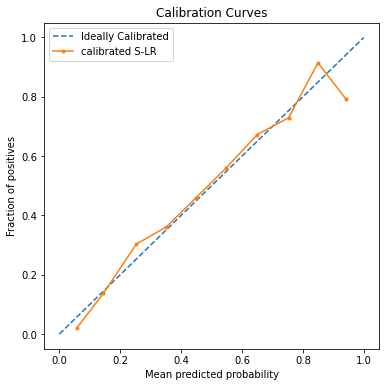

In [13]:
x, y_plot = calibration_curve(y, y_proba, n_bins = 10, normalize = True)
plt.figure(figsize=[6, 6])
# Plot a perfectly calibrated curve
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
# Plot model's calibration curve
plt.plot(y_plot, x, marker = '.', label = 'calibrated S-LR')
plt.title("Calibration Curves")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.legend(loc="upper left")
plt.savefig("calibration_curves_LR_pima_calib.svg")


In [14]:
df_w_groups_explained=X.copy()
df_w_groups_explained['target']=y
df_w_groups_explained['risk']=y_proba

writer = pd.ExcelWriter(r'features_explained_groups_train_set_pima.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
df_w_groups_explained.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
writer.save()

To investigate the decision curve, we saved the probabilities, that our model delivered. And now we import the package from R, that provides calculations and plots of decision curves.

In [15]:
#decision curve: R code
%load_ext rpy2.ipython


R[write to console]: New names:
* `` -> ...1

R[write to console]: Assuming '1' is [Event] and '0' is [non-Event]

R[write to console]: Printing with `plot(x, type = 'net_benefit', smooth = FALSE, show_ggplot_code = FALSE)`



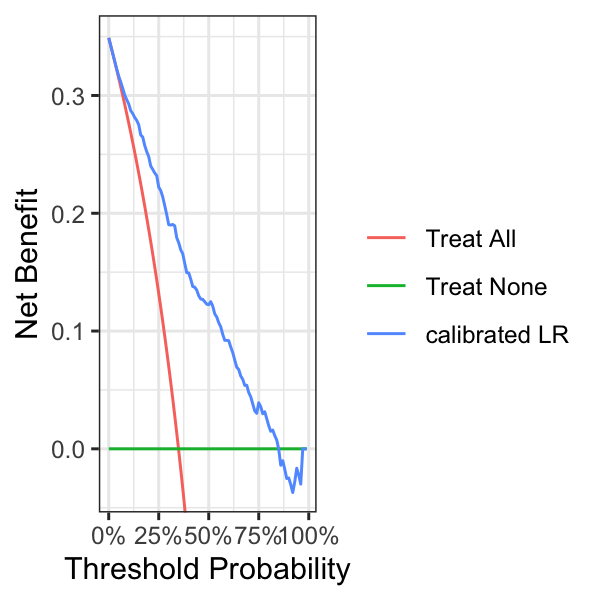

In [16]:
%%R  -w 3 -h 3 --units in -r 200
library(ggplot2)
library(readxl)
library(dcurves)

data_df_nn_S <- read_excel("features_explained_groups_train_set_pima.xlsx")
data_nn_S_calib<-data.frame(data_df_nn_S$target,data_df_nn_S$risk)
x <- c("target",  "calibrated LR")
colnames(data_nn_S_calib) <- x

dca(target  ~ `calibrated LR`,
    data = data_nn_S_calib,thresholds = seq(0., 1.0, by = 0.01)) 